In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam # is running better on M3 chip
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

#set the seed for reproducibility
seed = 55
# base 
base = "better-mura/MURA-v1.1/"

In [72]:
def get_data(df):
    data = []

    # only loading wrist images
    for index, row in df.iterrows():
        # wrist images
        if "XR_WRIST" in row['path']:
            image_path = os.path.join(base, row['path'])
            label = 1 if "positive" in row['path'] else 0

            if os.path.exists(image_path):
                data.append((image_path, label))
            else:
                print(f"Image not found: {image_path}")
    return data


Total images: 224045
Total wrist images: 59171


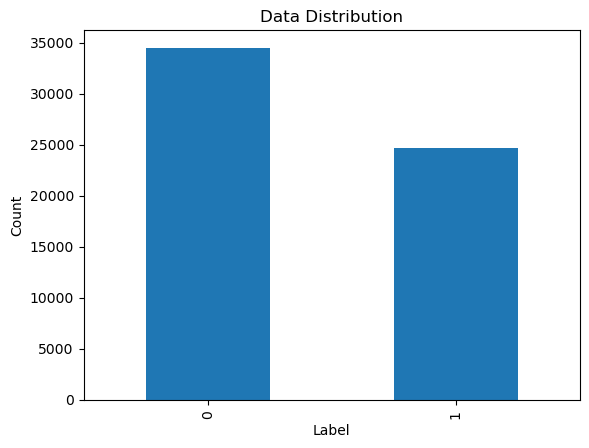

In [73]:
# Merging CSV files
df1 = pd.read_csv(f"{base}/MURA-v1.1/train_augmented.csv")
df2 = pd.read_csv(f"{base}/MURA-v1.1/valid.csv")

# Merge DataFrames and drop NaN values
df = pd.concat([df1, df2], ignore_index=True).dropna()
print(f"Total images: {len(df)}")

# get data
data = get_data(df)
print(f"Total wrist images: {len(data)}")
data = pd.DataFrame(data, columns=["path", "label"])
data.head()
# data distribution
data['label'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

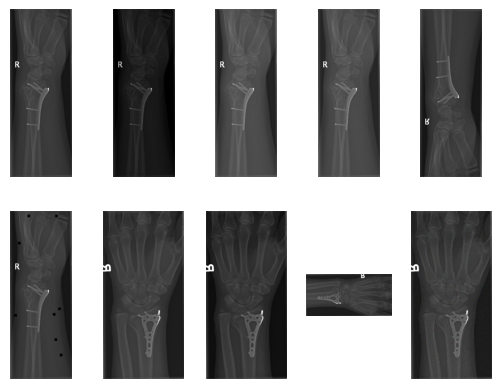

In [74]:
# show the first 10 images
for i in range(10):
    img = mpimg.imread(data['path'][i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [75]:
# split all dataset 10% test and 90% train and validation
# stratified splitting
train_df, test_df = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=seed)
print(f"Train images: {len(train_df)}")
print(f"Test images: {len(test_df)}")

Train images: 53253
Test images: 5918


In [76]:
# Define image data generator with augmentation
generator = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    brightness_range=(0.5, 1.5),
    validation_split=0.2  # Splitting within the generator itself
)

# Common parameters for train and validation generators
common_params = {
    "dataframe": train_df,
    "x_col": "path",
    "y_col": "label",
    "target_size": (224, 224),
    "color_mode": "rgb",
    "class_mode": "raw",
    "batch_size": 64,
    "shuffle": True,
    "seed": seed,
}

# Create=ing train and validation generators
train_images = generator.flow_from_dataframe(**common_params, subset="training")
val_images = generator.flow_from_dataframe(**common_params, subset="validation")

# Test generator (no data augmentation, no shuffling)
test_images = ImageDataGenerator().flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="raw",
    batch_size=32,
    shuffle=False
)


Found 42603 validated image filenames.
Found 10650 validated image filenames.
Found 5918 validated image filenames.


In [ ]:
# Load pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze most layers for feature extraction
for layer in pretrained_model.layers[:-10]:
    layer.trainable = False

# Build model
x = pretrained_model.output  # Feature vector output from ResNet50
x = Dense(12, activation='relu')(x)  # Fully connected layer
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification output

model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

# Define class weights to handle class imbalance
class_weights = {0: 1.0, 1: 1.5}  # Increase weight for fractures

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]

# Train the model with class weights
history = model.fit(train_images, validation_data=val_images, epochs=10, callbacks=callbacks, class_weight=class_weights)


Epoch 1/10


2025-03-23 16:19:35.494680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


666/666 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.7780

2025-03-23 16:52:44.472670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


666/666 [==============================] - 2463s 4s/step - loss: 0.5541 - accuracy: 0.7780 - val_loss: 0.4209 - val_accuracy: 0.8055
Epoch 2/10
666/666 [==============================] - 2536s 4s/step - loss: 0.4605 - accuracy: 0.8272 - val_loss: 0.3700 - val_accuracy: 0.8317
Epoch 3/10
666/666 [==============================] - 2891s 4s/step - loss: 0.4078 - accuracy: 0.8520 - val_loss: 0.3481 - val_accuracy: 0.8452
Epoch 4/10
666/666 [==============================] - 2513s 4s/step - loss: 0.3649 - accuracy: 0.8690 - val_loss: 0.3261 - val_accuracy: 0.8567
Epoch 5/10
666/666 [==============================] - 2464s 4s/step - loss: 0.3264 - accuracy: 0.8845 - val_loss: 0.3883 - val_accuracy: 0.8226
Epoch 6/10
666/666 [==============================] - 2560s 4s/step - loss: 0.2906 - accuracy: 0.9005 - val_loss: 0.2973 - val_accuracy: 0.8715
Epoch 7/10
666/666 [==============================] - 2659s 4s/step - loss: 0.2578 - accuracy: 0.9128 - val_loss: 0.2577 - val_accuracy: 0.8922
Epo

2025-03-24 23:41:12.097932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


185/185 [==============================] - 163s 879ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3451
           1       0.89      0.87      0.88      2467

    accuracy                           0.90      5918
   macro avg       0.90      0.90      0.90      5918
weighted avg       0.90      0.90      0.90      5918

ROC AUC Score: 0.963105575456354


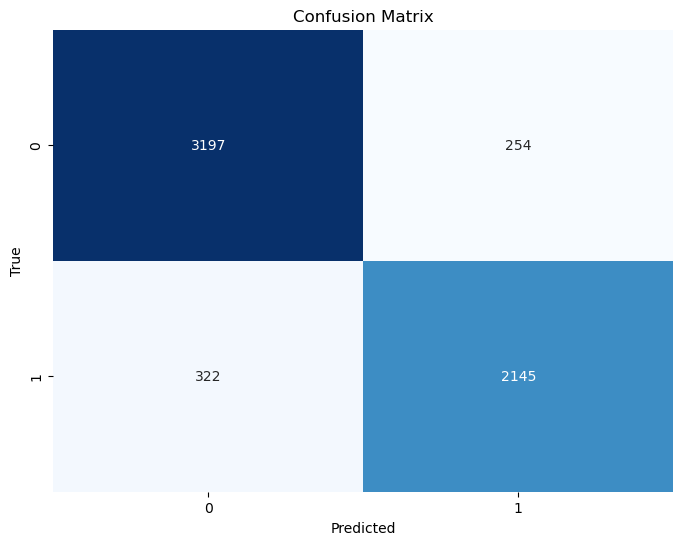

better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient03787/study1_negative/image2_aug_3_RandomBrightnessContrast.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient07236/study1_positive/image2_aug_3_CoarseDropout.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient05204/study1_negative/image2_aug_5_RandomBrightnessContrast.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08189/study1_negative/image3.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08386/study1_negative/image1_aug_3_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient07383/study1_positive/image1_aug_1_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08449/study1_negative/image1_aug_1_CoarseDropout.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06370/study1_positive/image1_aug_2_VerticalFlip.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patien

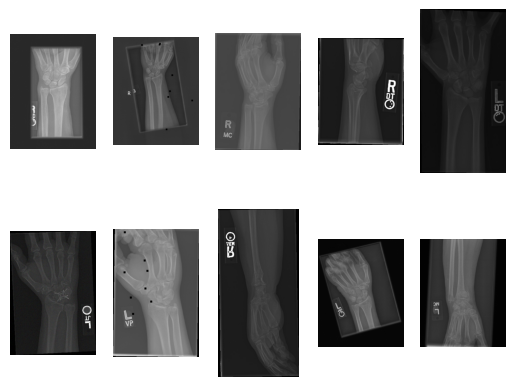

better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient07690/study1_negative/image1_aug_3_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient01761/study1_positive/image1_aug_2_RandomResizedCrop.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06380/study1_positive/image2_aug_5_RandomResizedCrop.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient03076/study1_positive/image1_aug_2_RandomBrightness.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08593/study1_negative/image3_aug_4_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08365/study1_negative/image3_aug_2_GaussNoise.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient01693/study1_positive/image3_aug_1_Blur.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient06853/study1_positive/image3_aug_3_Blur.jpg
better-mura/MURA-v1.1/MURA-v1.1/train_augmented/XR_WRIST/patient08441/stud

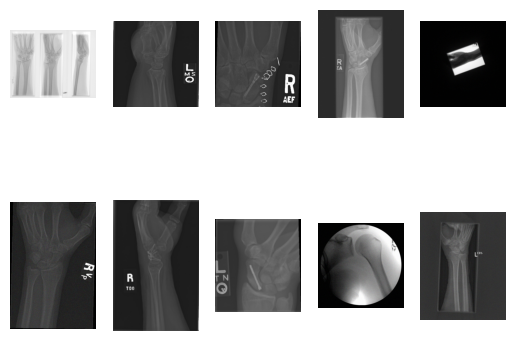

In [ ]:
# Predict on test data
y_pred_prob = model.predict(test_images)
y_pred = (y_pred_prob > 0.4).astype(int)  # Lower threshold to improve recall

# Extract true labels
true_labels = test_images.labels  

# Print classification report
print(classification_report(true_labels, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Confusion matrix

cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

# show which images are classified incorrectly
incorrect = test_df.loc[true_labels != y_pred.flatten()]
for i in range(10):
    print(incorrect['path'].iloc[i])
    img = mpimg.imread(incorrect['path'].iloc[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# show images classified correctly
correct = test_df.loc[true_labels == y_pred.flatten()]
for i in range(10):
    print(correct['path'].iloc[i])
    img = mpimg.imread(correct['path'].iloc[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [ ]:
results = model.evaluate(test_images, verbose=0)
print(" Results:")
print(results)
acc=np.round(results[1] * 100, 2)
print(f"Test Accuracy: {acc}%")
model.save(f"{acc}.h5")


2025-03-23 23:31:41.786723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 Results:
[0.24105054140090942, 0.9028388261795044]
Test Accuracy: 90.28%


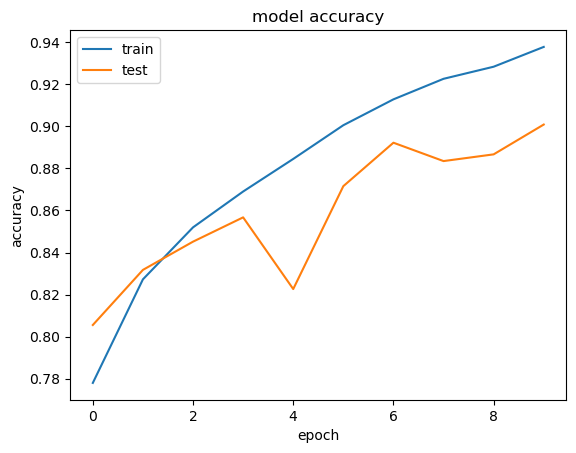

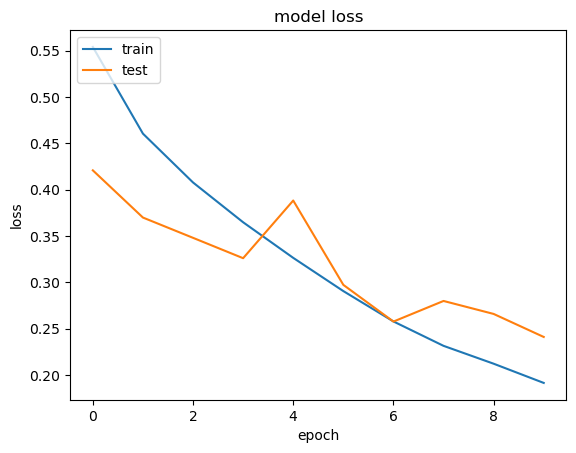

Model saved as model.h5
Done


In [80]:

# create plots for accuracy and save it
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# create plots for loss and save it
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# save the model
model.save("model.h5")
print("Model saved as model.h5")
print("Done")




In [83]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap.

    Parameters:
    - img_array: Preprocessed input image as NumPy array
    - model: Trained CNN model
    - last_conv_layer_name: The name of the last convolutional layer

    Returns:
    - heatmap: Normalized Grad-CAM heatmap
    """
    # Create a model that maps input image to activations & output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])  # Get predicted class index
        loss = predictions[:, class_idx]

    # Compute gradients of loss w.r.t. last conv layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled gradients with feature map
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize

    return heatmap

def overlay_gradcam(img_path, heatmap, alpha=0.4):
    """
    Overlays a Grad-CAM heatmap on an original image.

    Parameters:
    - img_path: Path to the original image
    - heatmap: Grad-CAM heatmap
    - alpha: Transparency factor for overlay

    Returns:
    - Blended image with heatmap overlay
    """
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to color map
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    
    return superimposed_img

# Preprocess image for model input
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Loads and preprocesses an image.

    Parameters:
    - img_path: Path to the image
    - target_size: Expected input size of the model

    Returns:
    - Preprocessed image as NumPy array
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

# Run Grad-CAM and visualize results
def run_gradcam(model, img_path, last_conv_layer_name="conv5_block3_out"):
    """
    Runs Grad-CAM and visualizes the result.

    Parameters:
    - model: Trained CNN model
    - img_path: Path to the test image
    - last_conv_layer_name: Name of the last convolutional layer
    """
    img_array = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed_img = overlay_gradcam(img_path, heatmap)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.show()
